## 5.2 モニタリング指標の異常検知と要因探索（小売りチェーン）

### 5.2.1 事例説明

2016年10月23日（土）と2016年10月24日（日）の売り上げが他の休日に比べて異常に低いのか検証する。

### 5.2.2 データセットと分析概要

-ARIMAモデルを活用  
-テーブルデータによる方法  
-線形回帰系のPLS回帰  
　-PLS回帰は目的変数yとの関係性を考慮した主成分を作る  
  -主成分回帰の主成分は目的変数yとの関係を考慮せず主成分を作る

### 5.2.3 Pythonの実施例

#### ざっくりした流れ

ステップ1:準備  
ステップ2:売上(y1)の異常検知  
ステップ3:客数(y21)と客単価(Y22)の異常検知  
ステップ4:客数(Y21)と関係している説明変数xの探索（要因探索）  
ステップ5:降水量(X2)と値引き率(X3)、チラシ配布量(X4)の異常検知

#### ステップ1:準備

#### code 5-16

In [1]:
# 必要なモジュールの読み込み

import numpy as np
import pandas as pd

from pmdarima import auto_arima
from pmdarima.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12,9]
plt.rcParams['font.size'] = 14

In [2]:
# 必要なデータセットの読み込み

dataset = 'chap5_2.csv'
df=pd.read_csv(dataset)

print(df)

           date day_of_the_week       y1  y21   y22    x1    x2     x3    x4  \
0      2016/6/6             Mon   818979  177  4627  18.3   0.0  0.006     0   
1      2016/6/7             Tue   789332  164  4813  19.8   0.9  0.002     0   
2      2016/6/8             Wed   793266  141  5626  22.8   0.5  0.002     0   
3      2016/6/9             Thu   721415  157  4595  23.1   7.0  0.005     0   
4     2016/6/10             Fri   796138  146  5453  22.2   0.0  0.003     0   
..          ...             ...      ...  ...   ...   ...   ...    ...   ...   
136  2016/10/20             Thu   799006  158  5052  20.8   0.0  0.002     0   
137  2016/10/21             Fri   822875  145  5687  17.8   0.5  0.007     0   
138  2016/10/22             Sat  1326138  142  9433  17.7  82.9  0.229  7500   
139  2016/10/23             Sun  1392365  155  9087  16.9  76.5  0.225  7500   
140  2016/10/24             Mon   689187  107  6403  17.3  10.8  0.010     0   

     holiday  
0          0  
1        

#### code 5-18

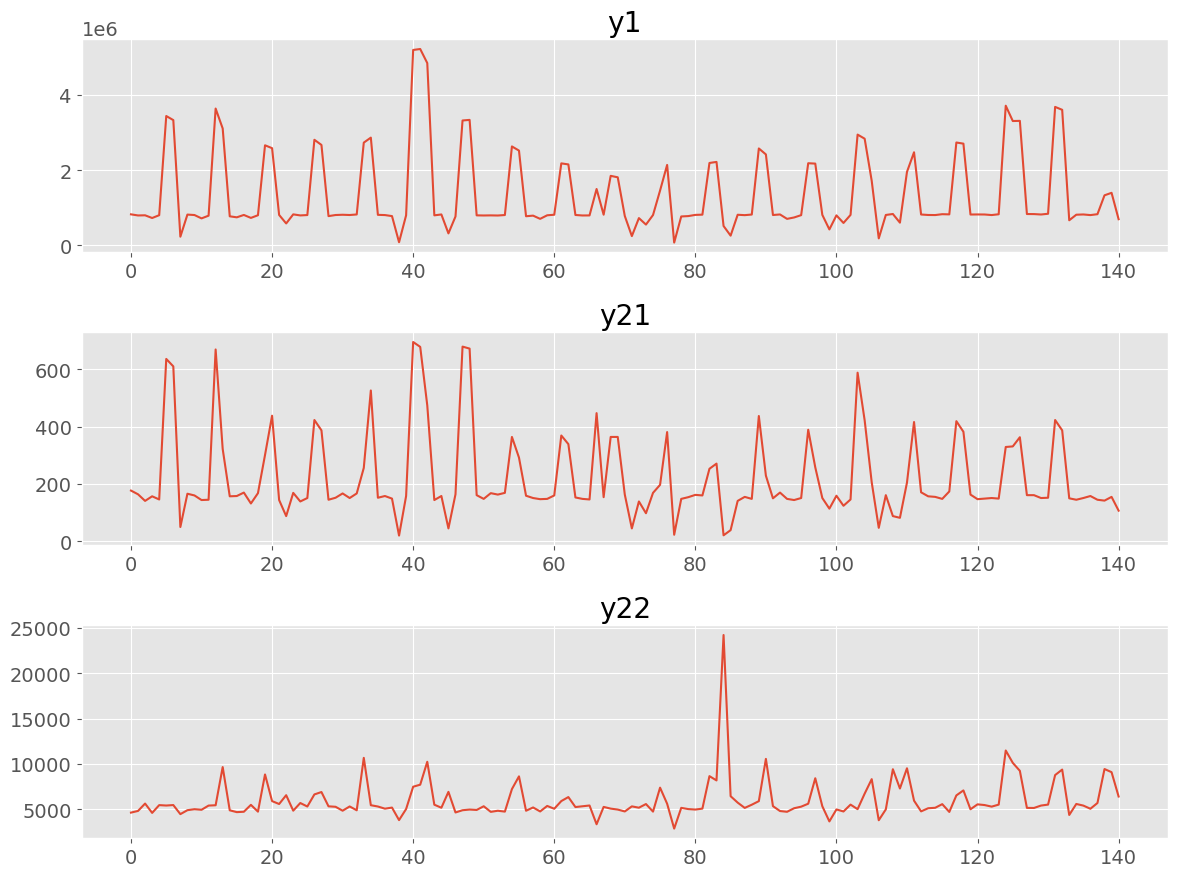

In [3]:
# グラフ（y1 売上、y21 客数、y22 客単価）

fig, ax = plt.subplots(3, 1, tight_layout=True)    # 3行1列  サブプロット間の余白を自動で調整し、見やすく配置する

for i in range(3):
    ax[i].plot(df.index, df.iloc[:,i+2])  # 3列目から5列目のデータを描画する
    ax[i].set_title(df.columns[i+2])

plt.show()

#### code 5-19

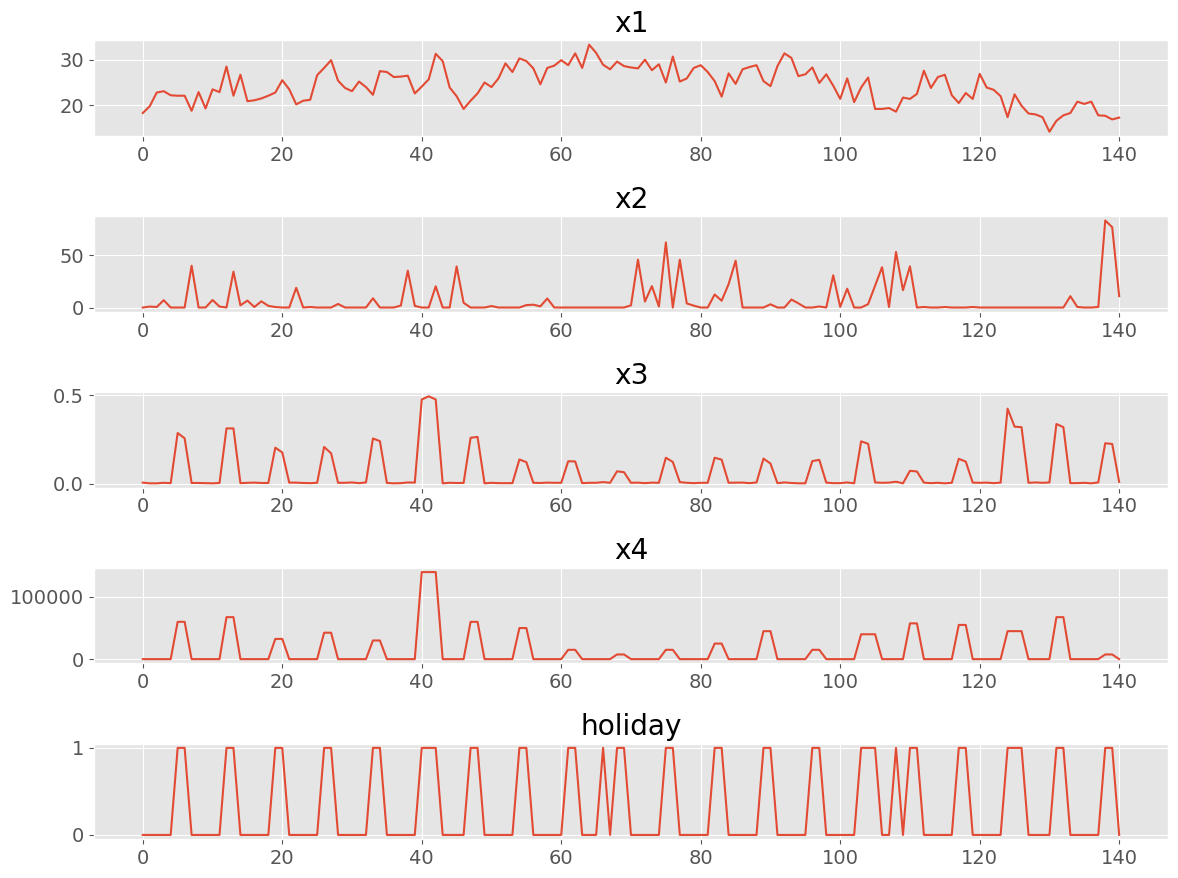

In [4]:
# グラフ（x1 気温、x2 降水量、x3 値引き率、x4 チラシ配布量、holiday 休日）

fig,ax = plt.subplots(5, 1, tight_layout=True)

for i in range(5):
    ax[i].plot(df.index, df.iloc[:,i+5])
    ax[i].set_title(df.columns[i+5])

plt.show()

#### code 5-20

In [5]:
# データセットをモデル構築用データと評価対象データ（直近7日間）に分割

target_length = 7  # 評価対象データが直近7期間

df_train, df_target = train_test_split(
    df,test_size=target_length)

In [6]:
range(3)

range(0, 3)

In [7]:
#i=0
df.iloc[:,2:5]

,y1,y21,y22
0,818979,177,4627
1,789332,164,4813
2,793266,141,5626
3,721415,157,4595
4,796138,146,5453
...,...,...,...
136,799006,158,5052
137,822875,145,5687
138,1326138,142,9433
139,1392365,155,9087


In [8]:
df

,date,day_of_the_week,y1,y21,y22,x1,x2,x3,x4,holiday
0,2016/6/6,Mon,818979,177,4627,18.3,0.0,0.006,0,0
1,2016/6/7,Tue,789332,164,4813,19.8,0.9,0.002,0,0
2,2016/6/8,Wed,793266,141,5626,22.8,0.5,0.002,0,0
3,2016/6/9,Thu,721415,157,4595,23.1,7.0,0.005,0,0
4,2016/6/10,Fri,796138,146,5453,22.2,0.0,0.003,0,0
...,...,...,...,...,...,...,...,...,...,...
136,2016/10/20,Thu,799006,158,5052,20.8,0.0,0.002,0,0
137,2016/10/21,Fri,822875,145,5687,17.8,0.5,0.007,0,0
138,2016/10/22,Sat,1326138,142,9433,17.7,82.9,0.229,7500,1
139,2016/10/23,Sun,1392365,155,9087,16.9,76.5,0.225,7500,1


#### code 5-21

時系列データの異常検知をするための関数「anomaly_detection」を作成する。  
この関数に、「モデル構築用データ」と「評価対象データ」をインプットすると「評価対象データ」の外れ値スコアが出力される。

In [9]:
# 関数定義

'''
関数名：
    anomaly_detection
引数：
    train_y  モデル構築用データ（NumPy配列）の目的変数y
    target_y  評価対象データ（NumPy配列）の目的変数y
    train_X モデル構築用データ（NumPy配列）の説明変数X
    target_X 評価対象データ（NumPy配列）の説明変数X
    seasonal_m 周期（周期なしのとき0と設定）
戻値（PandasのDataFrameとして返す）：
    train_result  モデル構築用データの期間の外れ値スコアなどの結果集約
  変数（戻値として出力されるデータフレームの変数）：
    y  実測値
    pred  予測値
    residual  残差
    std_res  標準化残差
    abs_std_res  外れ値スコア（標準化残差の絶対値）
'''


def anomaly_detection(train_y, target_y, train_X, target_X, seasonal_m):

    # 予測モデルの学習（モデル構築用データ利用）
    # seasonal_m が 0 より大きい場合は、季節性（seasonal=True）を考慮 した ARIMA モデルを使用します。
    # X=train_X によって、説明変数を考慮した回帰モデルも構築可能。
    if seasonal_m > 0:                   
        arima_model = auto_arima(
            train_y,
            X=train_X,
            seasonal=True,
            m=seasonal_m)

    else:
        arima_model = auto_arima(
            train_y,
            X=train_X,
            seasonal=False)

    # 残差（モデル構築用データの期間）
    train_pred = arima_model.predict_in_sample(X=train_X)  # predict_in_sample() で モデル構築用データに対する予測値 を計算。
    train_res = train_y[seasonal_m:] - train_pred[seasonal_m:]  # 実測値 train_y から予測値 train_pred を引いて 残差（residual） を求める。

    # 残差を標準化するモデルの学習
    # StandardScaler を使い、残差を標準化（zスコア変換）。
    # これにより、異常値をスコア化しやすくする。
    scaler = StandardScaler().fit(train_res.reshape(-1,1))    # -1:残りの要素数に応じて自動的にサイズを決める、1:1列のデータにして！」という指示

    # 標準化残差（モデル構築用データの期間）
    train_res_ss = scaler.transform(train_res.reshape(-1,1))

    # モデル構築用データの期間の外れ値スコアなどの結果集約
    # train_result（Pandas DataFrame） を作成し、y（実測値）、pred（予測値）、residual（残差 = y - pred）
    # std_res（標準化残差）、abs_std_res（標準化残差の絶対値 = 異常度スコア）を格納する。
    train_result = pd.DataFrame(
        np.concatenate(
            [train_y[seasonal_m:].reshape(-1,1),
            train_pred[seasonal_m:].reshape(-1,1),
            train_res.reshape(-1,1),
            train_res_ss,
            abs(train_res_ss)],
            axis=1),
        columns = ['y', 'pred', 'residual', 'std_res','abs_std_res'])

    # 残差（評価対象データの期間）
    target_pred = arima_model.predict(
            n_periods=len(target_y), X=target_X)  # predict() を使い、評価対象データ target_X の予測値 target_pred を算出。
    target_res = target_y-target_pred    # target_res = target_y - target_pred で残差を計算。

    # 標準化残差（評価対象データの期間）
    # 学習時と同じ StandardScaler を適用して標準化残差 target_res_ss を計算。
    target_res_ss = scaler.transform(target_res.reshape(-1,1))

    # 評価対象データの期間の外れ値スコアなどの結果集約
    # target_result（Pandas DataFrame）に、評価対象データの異常度スコア を格納。
    # 異常値スコア（abs_std_res）が大きいほど異常度が高い。
    target_result = pd.DataFrame(
        np.concatenate(
            [target_y.reshape(-1,1),
            target_pred.reshape(-1,1),
            target_res.reshape(-1,1),
            target_res_ss,
            abs(target_res_ss)],
         axis=1),
        columns = ['y', 'pred', 'residual', 'std_res', 'abs_std_res'])

    # 戻り値
    return train_result, target_result

#### ステップ2:売上（y1）の異常検知

異常検知をするために関数「anomaly_detection」を使い、「売上」（y1）の異常検知をする。

#### code 5-22

In [10]:
df_train.head()

,date,day_of_the_week,y1,y21,y22,x1,x2,x3,x4,holiday
0,2016/6/6,Mon,818979,177,4627,18.3,0.0,0.006,0,0
1,2016/6/7,Tue,789332,164,4813,19.8,0.9,0.002,0,0
2,2016/6/8,Wed,793266,141,5626,22.8,0.5,0.002,0,0
3,2016/6/9,Thu,721415,157,4595,23.1,7.0,0.005,0,0
4,2016/6/10,Fri,796138,146,5453,22.2,0.0,0.003,0,0


In [11]:
# 売上（y1）の異常検知

# 引数設定
seasonal_m = 7
train_y = df_train.y1.values
target_y = df_target.y1.values
train_X = df_train.holiday.values.reshape(-1,1)
target_X = df_target.holiday.values.reshape(-1,1)

# 関数実行
train_result, target_result = anomaly_detection(
    train_y,
    target_y,
    train_X,
    target_X,
    seasonal_m)

# 評価対象データの期間の外れ値スコア
print(target_result.abs_std_res)

0    0.124626
1    0.289900
2    0.679430
3    0.371815
4    3.759694
5    3.563634
6    0.044867
Name: abs_std_res, dtype: float64


項番4と5の外れ値スコアが3以上と高い。売上＝客数×客単価なので、どちらが異常か確かめる。

#### ステップ3：客数（y21）と客単価（y22）の異常検知

#### code 5-23

In [12]:
# 客数（y21）の異常検知

# 引数設定
seasonal_m = 7
train_y = df_train.y21.values
target_y = df_target.y21.values
train_X = df_train.holiday.values.reshape(-1,1)
target_X = df_target.holiday.values.reshape(-1,1)

# 関数実行
train_result, target_result = anomaly_detection(
    train_y,
    target_y,
    train_X,
    target_X,
    seasonal_m)

# 評価対象データの期間の外れ値スコアの確認
print(target_result.abs_std_res)

0    0.082801
1    0.134783
2    0.221809
3    0.026502
4    2.978926
5    2.824343
6    0.444785
Name: abs_std_res, dtype: float64


インデックス4と5が2以上なので客数（y21）が売上（y1）が悪化した要因と考えられる。  
客数（y21）を深堀して要因探索をした方がよい。

#### code 5-24

In [13]:
# 客単価（y22）の異常検知

# 引数設定
seasonal_m = 7
train_y = df_train.y22.values
target_y = df_target.y22.values
train_X = df_train.holiday.values.reshape(-1,1)
target_X = df_target.holiday.values.reshape(-1,1)

# 関数事項
train_result, target_result = anomaly_detection(
    train_y,
    target_y,
    train_X,
    target_X,
    seasonal_m)

# 評価対象データの期間の外れ値スコアの確認
print(target_result.abs_std_res)

0    0.121847
1    0.034968
2    0.133479
3    0.173008
4    0.964448
5    0.797449
6    0.518591
Name: abs_std_res, dtype: float64


すべて1以下なので、売上（y1）が悪化した要因として「客単価（y22）」を深堀するのは一旦やめる。  

「客数（y21）」悪化の要因を探る。  
悪化の要因候補として「気温（x1）」および「降水量（x2）」、「値引き率（x3）」、「チラシ配布量（x4）」を考える。  
各項目に関係があるのか相関係数を求めて確認する。

#### ステップ4：客数（y21）と関係している説明変数Xの探索（要因探索）

#### code 5-25

In [14]:
# 利用する目的変数yと説明変数Xの設定

# 利用データ
## 目的変数y
train_y = df_train[['y21']]
## 説明変数X
train_X = df_train.iloc[:,5:]

# 標準化
## 目的変数y
train_y_ss = StandardScaler().fit_transform(train_y)
## 説明変数X
train_X_ss = StandardScaler().fit_transform(train_X)

#### code 5-26

In [15]:
# PLS回帰モデルの学習

# モデルのインスタンス生成
PLS_model = PLSRegression()

# 学習
PLS_model.fit(train_X_ss, train_y_ss)

# R2（決定係数）
print('R2:\n', PLS_model.score(train_X_ss, train_y_ss))
print('------------------------------------------')

# 標準偏回帰係数の出力
print('partial regression coefficient:\n', PLS_model.coef_.reshape(-1,1))

R2:
 0.8489131723965102
------------------------------------------
partial regression coefficient:
 [[ 0.06146887]
 [-0.28234201]
 [ 0.30530618]
 [ 0.29584299]
 [ 0.32536175]]


#### code 5-27

In [16]:
np.array([1,2,3,4,5])


array([1, 2, 3, 4, 5])

In [17]:
 abs(PLS_model.coef_)[0]

array([0.06146887, 0.28234201, 0.30530618, 0.29584299, 0.32536175])

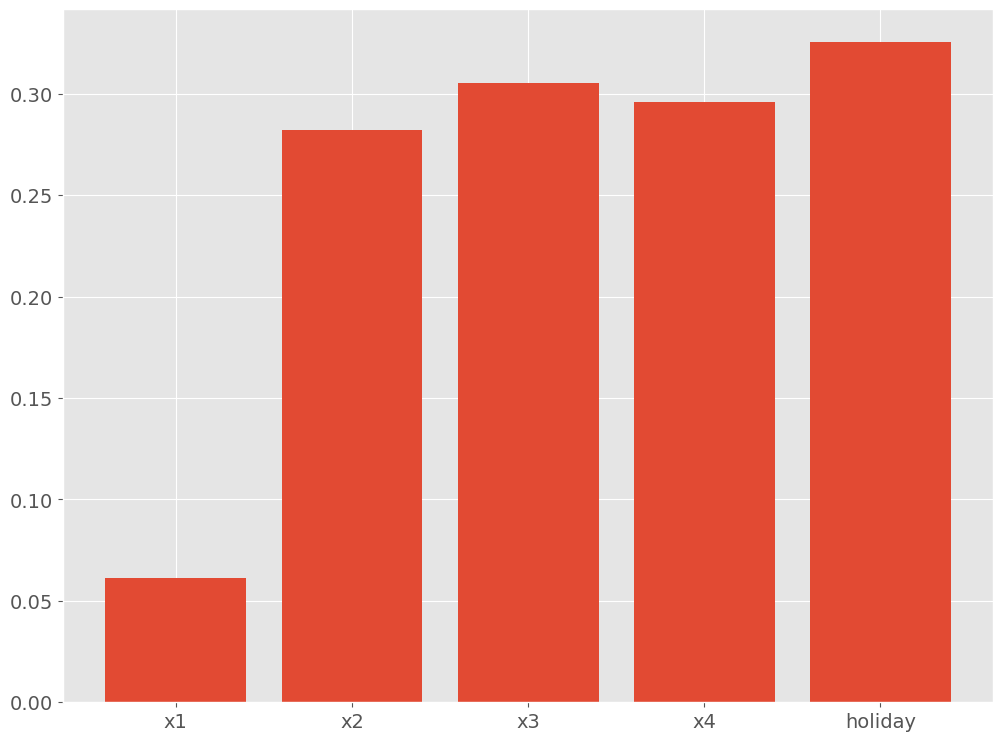

In [18]:
#
# グラフ化（偏回帰係数の絶対値）
#

plt.bar(
    np.array([1, 2, 3, 4, 5]),
    abs(PLS_model.coef_)[0,:],     # [:,0] → [0,:]
    tick_label=train_X.columns)

plt.show()

#### code 5-28

In [30]:
# x1の標準編回帰係数の絶対値が他と比べて極端に小さいので除く

# PLS回帰モデルの学習

# x1除外  train_X_ssの0番目の列を削除する
train_X_ss_del = np.delete(train_X_ss, 0,1)

# モデルのインスタンス生成
PLS_model = PLSRegression()

# 学習
PLS_model.fit(train_X_ss_del, train_y_ss)

# R2（決定係数）
print('R2:\n',PLS_model.score(train_X_ss_del, train_y_ss))
print('-------------------------------------------')

# 標準偏回帰係数の出力
print('partial regression coefficient:\n', PLS_model.coef_.reshape(-1,1))

R2:
 0.8478675709830844
-------------------------------------------
partial regression coefficient:
 [[-0.29672217]
 [ 0.30287494]
 [ 0.29350818]
 [ 0.32616844]]


#### ステップ5：降水量（x2）と値引き率（x3）、チラシ配布量（x4）の異常検知

降水量および値引き率、チラシ配布量が20116年10月22日（土）と10月23日（日）に好ましくない異常変化をしたことで、客数を悪化させた要因があるかもしれない。

#### code 5-29

In [41]:
# 降水量（x2）の異常検知

# 引数設定
seasonal_m = 0
train_y = df_train.x2.values
target_y = df_target.x2.values
train_X = df_train.holiday.values.reshape(-1,1)  # reshape(-1,1) は、1D 配列を 2D に変換するために使う。
target_X = df_target.holiday.values.reshape(-1,1)

# 関数実行
train_ressult, target_result = anomaly_detection(
    train_y,
    target_y,
    train_X,
    target_X,
    seasonal_m)

# 評価対象データの期間の外れ値スコアの確認
print(target_result.abs_std_res)

0    0.335238
1    0.621435
2    0.467062
3    0.497116
4    6.468238
5    5.914739
6    0.397801
Name: abs_std_res, dtype: float64


レコードのインデックス4と5の外れ値スコアが3以上と高いことが分かる。  
客数が悪化した要因として降水量（x2）が考えられる。  

次に値引き率（x3）の異常検知を行う。  
値引きは平日も休日も実施しているが、休日に重点的に実施しているため、周期的に実施しているようにみえるだけである。  
データ期間が長ければ、同じ休日でも年周期で傾向があるかもしれないが、データ期間が数か月と短いこともあり、値引き率の季節性は現れないと想定し、異常検知を実施する。

#### code 5-30

In [44]:
# 値引き率（x3）の異常検知

# 引数設定
seasonal_m = 0
train_y = df_train.x3.values
target_y = df_target.x3.values
train_X = df_train.holiday.values.reshape(-1,1)
target_X = df_target.holiday.values.reshape(-1,1)

# 関数実行
train_result, target_result = anomaly_detection(
    train_y,
    target_y,
    train_X,
    target_X,
    seasonal_m)

# 評価対象データの期間の外れ値スコアの確認
print(target_result.abs_std_res)

0    0.042327
1    0.002564
2    0.040504
3    0.044004
4    0.600228
5    0.535583
6    0.095370
Name: abs_std_res, dtype: float64


すべて1未満なので、値引き率（x3）客数（y21）が減った要因とは考えにくい。

チラシ配布量（x4）の異常検知はもチラシ配布量の季節性は現れないと想定して異常検知を実施する。

In [48]:
# チラシ配布量（x4）の異常検知

# 引数設定
seasonal_m = 0
train_y = df_train.x4.values
target_y = df_target.x4.values
train_X = df_train.holiday.values.reshape(-1,1)
target_X = df_target.holiday.values.reshape(-1,1)

# 関数実行
train_result, target_result = anomaly_detection(
    train_y,
    target_y,
    train_X,
    target_X,
    seasonal_m)

# 評価対象データの期間の外れ値スコアの確認
print(target_result.abs_std_res)

0    1.859299e-10
1    1.859299e-10
2    1.859298e-10
3    1.859298e-10
4    2.517872e+00
5    2.517872e+00
6    1.859298e-10
Name: abs_std_res, dtype: float64


レコードのインデックス4と5の外れ値スコアが2以上高いことから、客数（y21）が悪化した要因としてチラシ配布量（x4）が考えられる。

まとめると、降水量（x2）とチラシ配布量（x4）の影響で客数（y21）が悪化し、客数（y21）が悪化したことで売上（y1）が悪化したと言えそうである。

この結果を踏まえてどうするかは、対策を練るための「どうするどうする分析」を行う。  
5.3節で説明する。